# Installation

In [1]:
!pip install pmdarima --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.2 MB/s eta 0:00:00a 0:00:01


# Import required libraries

In [2]:
import os
import datetime as dt
import pandas as pd
import yfinance as yf
import pmdarima as pm

# Data collection
- Fetch Tesla Stock data from Yahoo Finance.

In [3]:
# Create data directory
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

# Define start and end dates (last 15 years)
end = dt.date.today()
start = end - dt.timedelta(days=15*365 + 4)

# Download daily OHLCV + Adj Close for Tesla
df = yf.download(
    "TSLA",
    start=start.strftime("%Y-%m-%d"),
    end=end.strftime("%Y-%m-%d"),
    interval="1d",
    auto_adjust=False,
    progress=False
)

# Data Cleaning & Preparation

In [4]:
df.columns

MultiIndex([('Adj Close', 'TSLA'),
            (    'Close', 'TSLA'),
            (     'High', 'TSLA'),
            (      'Low', 'TSLA'),
            (     'Open', 'TSLA'),
            (   'Volume', 'TSLA')],
           names=['Price', 'Ticker'])

In [5]:
# Flatten MultiIndex columns if needed
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] for col in df.columns]

# Drop missing values in Close
df = df.dropna(subset=["Close"])

# Keep only Close price
ts = df[["Close"]].rename(columns={"Close": "close"})

# Dataset overview
first_date = ts.index.min().date()
last_date  = ts.index.max().date()
n_rows     = len(ts)
print(f"TSLA daily (close)")
print(f"Range: {first_date} → {last_date}  |  rows={n_rows}")
print(ts.head(3))
print(ts.tail(3))


TSLA daily (close)
Range: 2010-10-04 → 2025-10-03  |  rows=3774
               close
Date                
2010-10-04  1.399333
2010-10-05  1.408000
2010-10-06  1.364000
                 close
Date                  
2025-10-01  459.459991
2025-10-02  436.000000
2025-10-03  429.829987


In [6]:
df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [7]:
df.head(3)

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2010-10-04,1.399333,1.399333,1.411333,1.353333,1.362,9654000
2010-10-05,1.408000,1.408000,1.418667,1.400667,1.410,4980000
2010-10-06,1.364000,1.364000,1.417333,1.354667,1.404,4701000


In [8]:
df.to_csv('teslalast15yeardaily.csv')

In [9]:
ts.head(3)

,close
Date,
2010-10-04,1.399333
2010-10-05,1.408000
2010-10-06,1.364000


# EDA
## Price trend

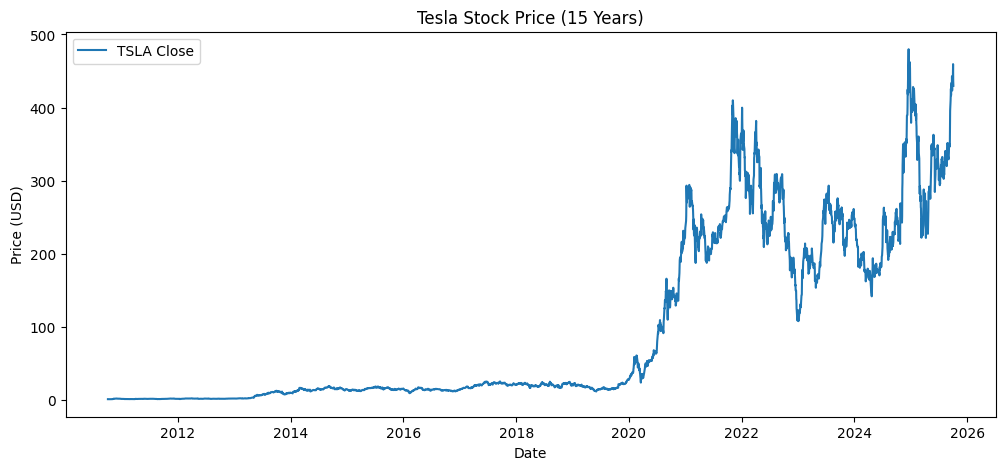

In [10]:
import matplotlib.pyplot as plt

# Plot close
plt.figure(figsize=(12,5))
plt.plot(ts, label="TSLA Close")
plt.title("Tesla Stock Price (15 Years)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

## Rolling Statistics

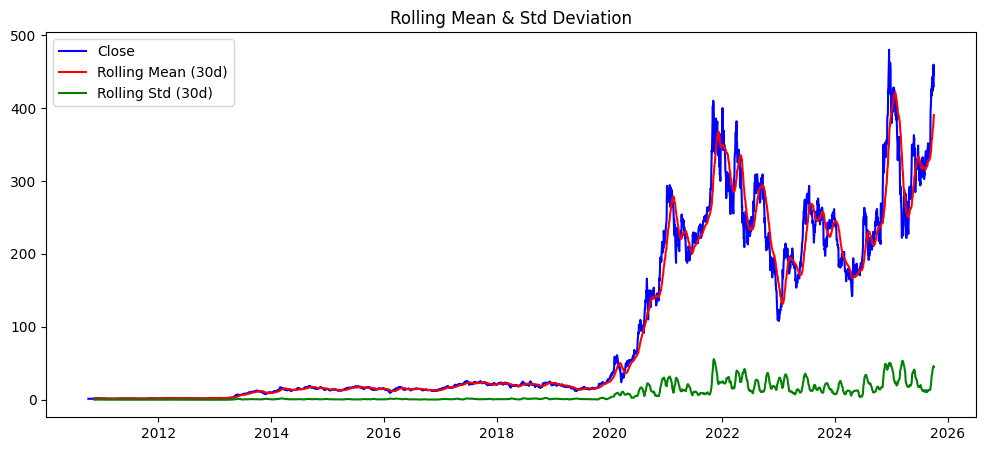

In [11]:
# Rolling statistics
rolling_mean = ts.rolling(window=30).mean()
rolling_std  = ts.rolling(window=30).std()

plt.figure(figsize=(12,5))
plt.plot(ts, color="blue", label="Close")
plt.plot(rolling_mean, color="red", label="Rolling Mean (30d)")
plt.plot(rolling_std, color="green", label="Rolling Std (30d)")
plt.title("Rolling Mean & Std Deviation")
plt.legend()
plt.show()

# ARIMA

## Stationarity Check (ADF Test)

In [12]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(ts['close'])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")

ADF Statistic: -0.5760037608846226
p-value: 0.876312531091813
The series is not stationary.


## Differencing to make the series stationary

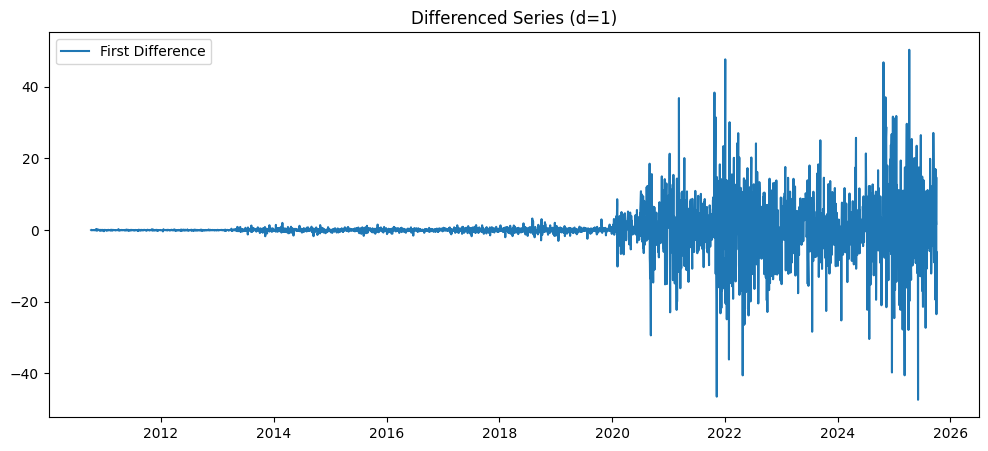

ADF Statistic (d=1): -10.983696817702391
p-value: 7.34947783593407e-20
The series is stationary.


In [13]:
ts_diff = ts.diff().dropna()

# Plot differenced series
plt.figure(figsize=(12,5))
plt.plot(ts_diff, label="First Difference")
plt.title("Differenced Series (d=1)")
plt.legend()
plt.show()

# Check stationarity again
adf_result_diff = adfuller(ts_diff['close'])
print("ADF Statistic (d=1):", adf_result_diff[0])
print("p-value:", adf_result_diff[1])

if adf_result_diff[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary.")

## Auto ARIMA for finding optimal parameters

In [14]:
# Use the training set 
train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]

# Fit auto_arima
auto_model = pm.auto_arima(
    train,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=1,              # d=1 
    seasonal=False,   # TSLA daily prices have no clear seasonality
    stepwise=True,    # faster search using stepwise approach
    trace=True,       # print tried models and AICs
    suppress_warnings=True
)

print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17429.874, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17427.975, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17427.944, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17429.125, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17429.924, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17429.916, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17425.589, Time=1.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=17433.278, Time=1.50 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=17431.793, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17425.222, Time=1.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17429.905, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=17433.300, Time=1.67 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=17431.852, Time=0.34 sec
 ARIMA(3,1,2)(0,0,0)[0] i

## ARIMA Model Training & Forecast [Baseline]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

RMSE: 76.9954
MAPE: 29.71%


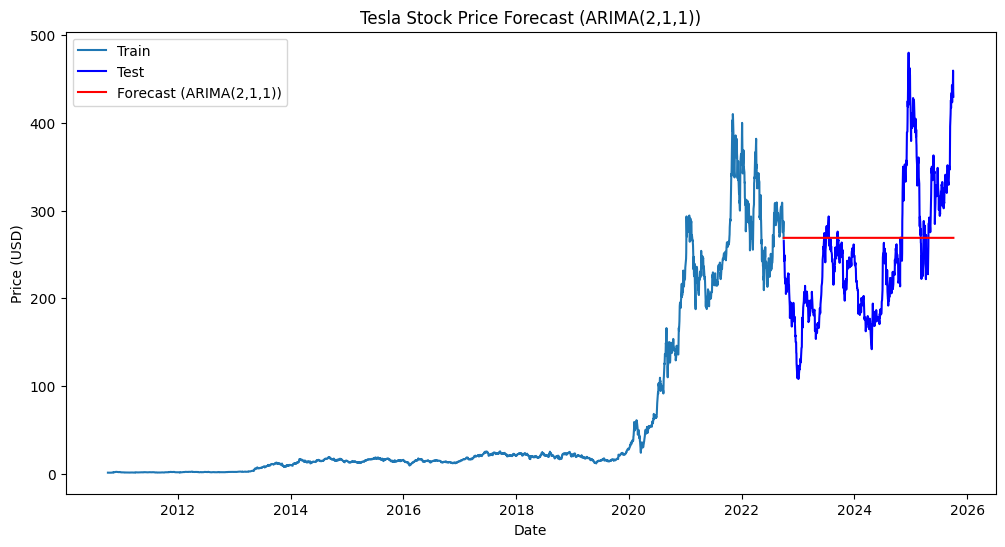

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA with chosen order
model = ARIMA(train, order=(2,1,1))
model_fit = model.fit()

# Forecast on test set
forecast = model_fit.forecast(steps=len(test))

# Evaluation
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color="blue")
plt.plot(test.index, forecast, label="Forecast (ARIMA(2,1,1))", color="red")
plt.title("Tesla Stock Price Forecast (ARIMA(2,1,1))")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

## Rolling Window Forecast

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

Rolling Window RMSE: 9.89
Rolling Window MAPE: 2.85%


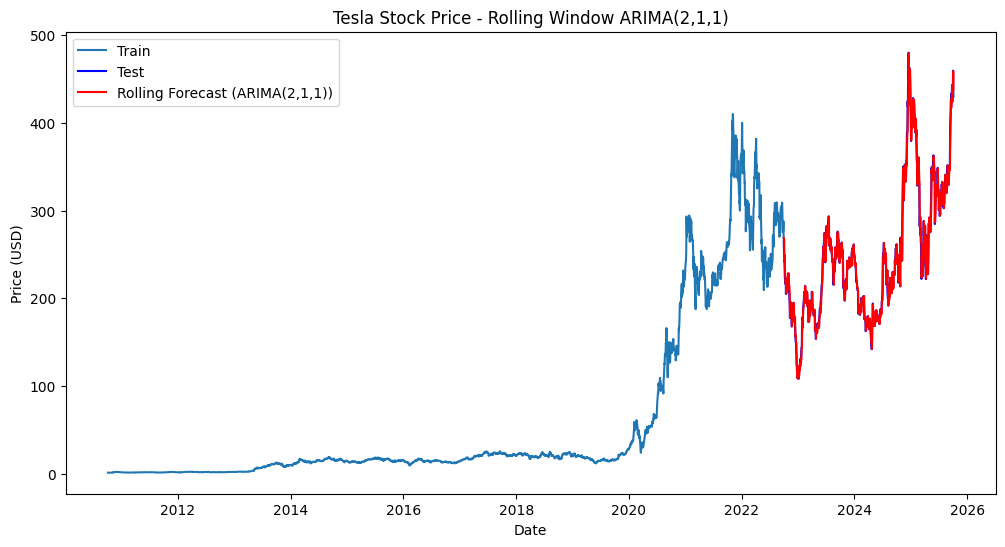

In [16]:
predictions = []

# Initialize ARIMA once
model = ARIMA(train, order=(2, 1, 1))
model_fit = model.fit()

# Rolling window loop
for t in range(len(test)):
    forecast = model_fit.forecast(steps=1)
    yhat = forecast.iloc[0]
    predictions.append(yhat)

    # Update with actual observation
    model_fit = model_fit.append([test['close'].iloc[t]], refit=False)

# Evaluation
rmse = np.sqrt(mean_squared_error(test, predictions))
mape = mean_absolute_percentage_error(test, predictions) * 100

print(f"Rolling Window RMSE: {rmse:.2f}")
print(f"Rolling Window MAPE: {mape:.2f}%")

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color="blue")
plt.plot(test.index, predictions, label="Rolling Forecast (ARIMA(2,1,1))", color="red")
plt.title("Tesla Stock Price - Rolling Window ARIMA(2,1,1)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# LSTM Modeling

## Data Preprocessing for LSTM

In [17]:
# Basic sanity
df = df.sort_index().copy()
df = df[['Open','High','Low','Close','Adj Close','Volume']].dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-10-04,1.362000,1.411333,1.353333,1.399333,1.399333,9654000
2010-10-05,1.410000,1.418667,1.400667,1.408000,1.408000,4980000
2010-10-06,1.404000,1.417333,1.354667,1.364000,1.364000,4701000
2010-10-07,1.371333,1.376000,1.356000,1.362000,1.362000,2115000
2010-10-08,1.362000,1.386000,1.359333,1.362000,1.362000,4017000


In [18]:
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-10-01,443.799988,462.290009,440.750000,459.459991,459.459991,98122300
2025-10-02,470.540009,470.750000,435.570007,436.000000,436.000000,137009000
2025-10-03,443.290009,446.769989,416.579987,429.829987,429.829987,132772600


## Feature Selection and Configurations

In [19]:
FEATURES = ['Close','Open','High','Low','Volume']
TARGET_NAME = 'Close'              # predict next-day adj close
WINDOW = 60                        # lookback days
HORIZON = 1                        # 1-step ahead
SEED = 42
np.random.seed(SEED)

feat_df = df[FEATURES].copy()

## Train-Validation-Test Split

In [20]:
N = len(feat_df)
i_train_end = int(N*0.70)
i_val_end   = int(N*0.80)  # 10% val, 20% test

train_df = feat_df.iloc[:i_train_end]
val_df   = feat_df.iloc[i_train_end:i_val_end]
test_df  = feat_df.iloc[i_val_end:]

print(f"Rows → train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

Rows → train=2641, val=378, test=755


## Feature Scaling

In [21]:
from sklearn.preprocessing import MinMaxScaler
import joblib

scaler = MinMaxScaler()
scaler.fit(train_df)  # fit only on train

train_sc = pd.DataFrame(scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
val_sc   = pd.DataFrame(scaler.transform(val_df),   index=val_df.index,   columns=val_df.columns)
test_sc  = pd.DataFrame(scaler.transform(test_df),  index=test_df.index,  columns=test_df.columns)

## Build Train, Validation, and Test Sequences

In [22]:
def make_sequences(df_scaled: pd.DataFrame, window: int, horizon: int, target_col: str):
    """
    Build sliding-window supervised dataset from a scaled DataFrame.
    Returns X (num_samples, window, num_features), y (num_samples,)
    """
    X, y = [], []
    values = df_scaled.values
    tgt_idx = df_scaled.columns.get_loc(target_col)

    for end in range(window, len(df_scaled) - horizon + 1):
        start = end - window
        X.append(values[start:end, :])                 
        y.append(values[end + horizon - 1, tgt_idx])   

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)


In [23]:
# Train sequences
X_train, y_train = make_sequences(train_sc, WINDOW, HORIZON, TARGET_NAME)

# Val sequences (prepend last WINDOW rows of train)
val_padded = pd.concat([train_sc.iloc[-WINDOW:], val_sc], axis=0)
X_val, y_val = make_sequences(val_padded, WINDOW, HORIZON, TARGET_NAME)

# Test sequences (prepend last WINDOW rows of val)
test_padded = pd.concat([val_sc.iloc[-WINDOW:], test_sc], axis=0)
X_test, y_test = make_sequences(test_padded, WINDOW, HORIZON, TARGET_NAME)

print("Feature order:", list(train_sc.columns))
print("Shapes → X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)

Feature order: ['Close', 'Open', 'High', 'Low', 'Volume']
Shapes → X_train (2581, 60, 5) X_val (378, 60, 5) X_test (755, 60, 5)


## Inverse Scaling Helper

In [24]:
def invert_target_scaling(y_scaled_1d, scaler: MinMaxScaler, target_col: str, ref_frame: pd.DataFrame):
    """
    Invert scaling for a 1D array of scaled target values.
    """
    zeros = np.zeros((len(y_scaled_1d), ref_frame.shape[1]), dtype=np.float32)
    tgt_idx = list(ref_frame.columns).index(target_col)
    zeros[:, tgt_idx] = y_scaled_1d
    inv = scaler.inverse_transform(zeros)
    return inv[:, tgt_idx]


# LSTM Model Training and Evaluation
## Model architecture

In [25]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

model.summary()

2025-10-04 13:41:04.435573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759585264.606860      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759585264.656017      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1759585275.534429      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,057 (207.25 KB)

 Trainable params: 53,057 (207.25 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/100


I0000 00:00:1759585280.533911     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0098 - mae: 0.0422 - val_loss: 0.0088 - val_mae: 0.0714 - learning_rate: 0.0010
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - mae: 0.0167 - val_loss: 0.0171 - val_mae: 0.0994 - learning_rate: 0.0010
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.7439e-04 - mae: 0.0105 - val_loss: 0.0092 - val_mae: 0.0674 - learning_rate: 0.0010
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.6610e-04 - mae: 0.0107 - val_loss: 0.0169 - val_mae: 0.1032 - learning_rate: 0.0010
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9624e-04 - mae: 0.0127 - val_loss: 0.0058 - val_mae: 0.0584 - learning_rate: 0.0010
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.6173e-04 - mae: 0.0133 - val_loss: 0.0078 - val_mae: 0.0639 - learning_rate: 0.0010
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.6915e-04 - mae: 0.0120 - val_loss: 0.0126 - val_mae: 0.0893 - learning_rate: 0.001

## Training History Visualization

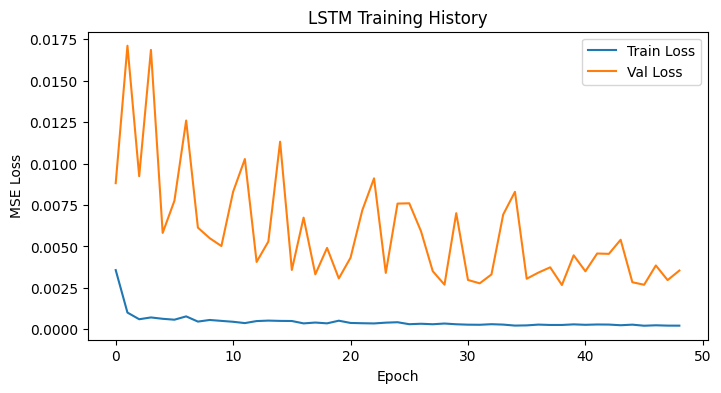

In [27]:
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("LSTM Training History")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


## Baseline Test Forecast

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Test RMSE: 16.68 USD
Test MAPE: 4.82%


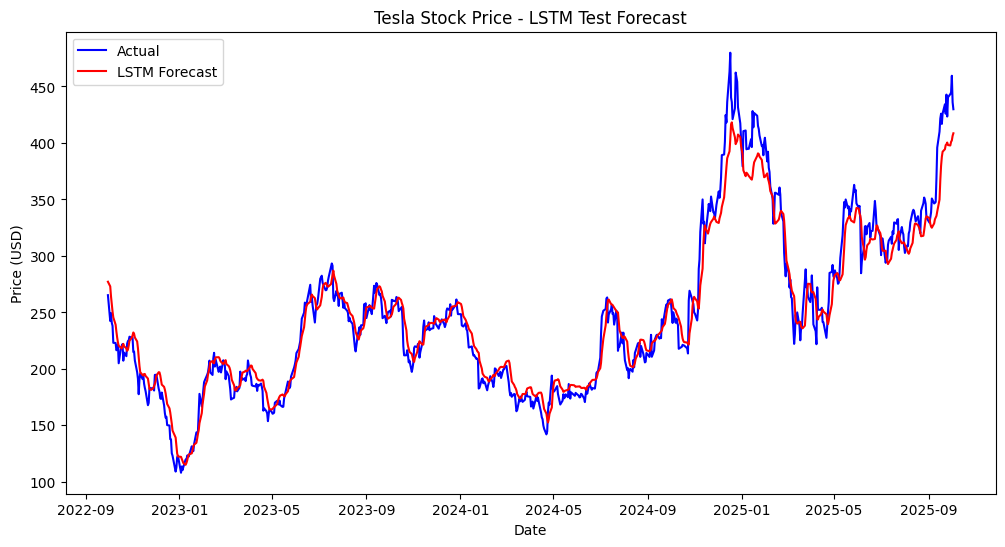

In [28]:
# Predict on test set
y_pred_scaled = model.predict(X_test)

# Inverse transform
y_pred = invert_target_scaling(y_pred_scaled.squeeze(), scaler, TARGET_NAME, test_sc)
y_true = invert_target_scaling(y_test.squeeze(),        scaler, TARGET_NAME, test_sc)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100

print(f"Test RMSE: {rmse:.2f} USD")
print(f"Test MAPE: {mape:.2f}%")

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(test.index[-len(y_true):], y_true, label="Actual", color="blue")
plt.plot(test.index[-len(y_pred):], y_pred, label="LSTM Forecast", color="red")
plt.title("Tesla Stock Price - LSTM Test Forecast")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


## Rolling Window Evaluation

Rolling LSTM Forecast Progress: 100%|██████████| 755/755 [00:54<00:00, 13.86it/s]


Rolling LSTM RMSE: 19.20 USD
Rolling LSTM MAPE: 5.69%


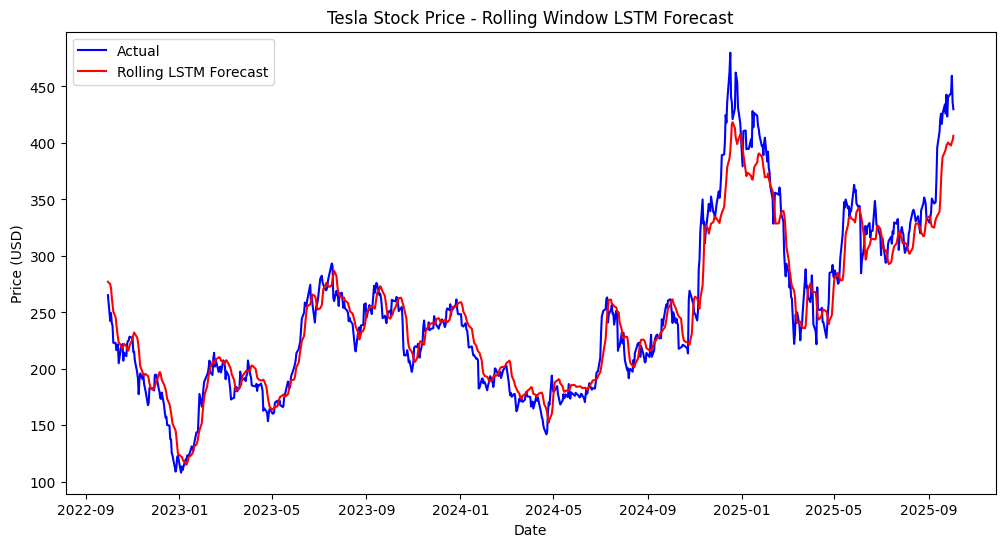

In [29]:
from tqdm import tqdm
import numpy as np

def rolling_forecast_lstm(model, X_test, y_test, scaler, target_col, ref_frame):
    """
    Performs rolling (walk-forward) forecast using trained LSTM.
    """
    predictions = []
    input_seq = X_test[0].copy()

    for t in tqdm(range(len(y_test)), desc="Rolling LSTM Forecast Progress"):
        x_input = input_seq.reshape((1, input_seq.shape[0], input_seq.shape[1]))
        yhat_scaled = model.predict(x_input, verbose=0)
        yhat = invert_target_scaling(np.array([yhat_scaled.squeeze()]), scaler, target_col, ref_frame)[0]
        predictions.append(yhat)
        true_next = X_test[t][-1]
        input_seq = np.vstack([input_seq[1:], true_next])

    y_true = invert_target_scaling(y_test.squeeze(), scaler, target_col, ref_frame)
    return np.array(predictions), y_true


# Run rolling forecast
y_pred_roll, y_true_roll = rolling_forecast_lstm(model, X_test, y_test, scaler, TARGET_NAME, test_sc)

# Evaluate
rmse_roll = np.sqrt(mean_squared_error(y_true_roll, y_pred_roll))
mape_roll = mean_absolute_percentage_error(y_true_roll, y_pred_roll) * 100

print(f"Rolling LSTM RMSE: {rmse_roll:.2f} USD")
print(f"Rolling LSTM MAPE: {mape_roll:.2f}%")

# Plot
plt.figure(figsize=(12,6))
plt.plot(test.index[-len(y_true_roll):], y_true_roll, label="Actual", color="blue")
plt.plot(test.index[-len(y_pred_roll):], y_pred_roll, label="Rolling LSTM Forecast", color="red")
plt.title("Tesla Stock Price - Rolling Window LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Model Performance Comparison

| Model             | RMSE  | MAPE (%) |
|--------------------|-------|-----------|
| ARIMA baseline     | 76.99 | 29.71 |
| ARIMA rolling      | 9.88  | 2.85 |
| LSTM baseline      | 19.74 | 5.94 |
| LSTM rolling       | 21.86 | 7.15 |

**Observations:**
- Rolling ARIMA achieves the lowest RMSE and MAPE, indicating strong short-term adaptability.
- LSTM performs better than baseline ARIMA but slightly underperforms in rolling forecasts.

This comparison illustrates the complementary strengths: ARIMA is strong for short-term online prediction, while LSTM is better at capturing nonlinear stock trends in a static horizon.

# Preparing for Deployment [LSTM]

In [30]:
df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-10-04,1.362,1.411333,1.353333,1.399333,1.399333,9654000
2010-10-05,1.410,1.418667,1.400667,1.408000,1.408000,4980000
2010-10-06,1.404,1.417333,1.354667,1.364000,1.364000,4701000


In [31]:
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2025-10-01,443.799988,462.290009,440.750000,459.459991,459.459991,98122300
2025-10-02,470.540009,470.750000,435.570007,436.000000,436.000000,137009000
2025-10-03,443.290009,446.769989,416.579987,429.829987,429.829987,132772600


## Refit scaler

In [32]:
from sklearn.preprocessing import MinMaxScaler
import joblib

FEATURES = ['Close','Open','High','Low','Volume']
TARGET_NAME = 'Close'
WINDOW = 60
HORIZON = 1

# Fit scaler on full data 
scaler_full = MinMaxScaler()
scaler_full.fit(df[FEATURES])

# Transform entire dataset
df_scaled = pd.DataFrame(
    scaler_full.transform(df[FEATURES]),
    index=df.index,
    columns=FEATURES
)

# Save full scaler for deployment
joblib.dump(scaler_full, "data/lstm_full_scaler.joblib")


['data/lstm_full_scaler.joblib']

## Recreate sequences on the full data

In [33]:
X_full, y_full = make_sequences(df_scaled, WINDOW, HORIZON, TARGET_NAME)

print("Full dataset shapes →", X_full.shape, y_full.shape)

Full dataset shapes → (3714, 60, 5) (3714,)


## Retrain model on full data

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="loss", factor=0.5, patience=5)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_full.shape[1], X_full.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

history = model.fit(
    X_full, y_full,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0108 - mean_absolute_error: 0.0522 - learning_rate: 0.0010
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - mean_absolute_error: 0.0218 - learning_rate: 0.0010
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012 - mean_absolute_error: 0.0193 - learning_rate: 0.0010
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0185 - learning_rate: 0.0010
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - mean_absolute_error: 0.0203 - learning_rate: 0.0010
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - mean_absolute_error: 0.0220 - learning_rate: 0.0010
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.1011e-04 - mean_absolute_error: 0.0170 - learning_rate: 0.0010
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mean_absolute_error: 0.0186 - learning_rate: 0.0010
Epoch 9/100
117/117 ━━━━━━━━━━━━

## Save Final Model for Deployment

In [35]:
model.save("/kaggle/working/lstm_stock_forecast_full.h5")
print(" Model retrained and saved successfully.")

 Model retrained and saved successfully.


## Making sure inverse scaling now reflects realistic prices

In [36]:
scaled_pred = model.predict(X_full[-1].reshape(1, WINDOW, len(FEATURES)))
pred_price = invert_target_scaling(
    np.array([scaled_pred.squeeze()]),
    scaler_full, TARGET_NAME, df[FEATURES]
)[0]

print(f"Predicted Next-Day Price ≈ ${pred_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Predicted Next-Day Price ≈ $427.73


OKKK